In [1]:
# - Install requirements for this notebook
# %pip install --quiet rockpool matplotlib torch tonic rich jax jaxlib xylosim samna bitstruct

# - Import and configure matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["figure.dpi"] = 300

# - Nice printing
from rich import print

# - Torch and numpy
import torch
import numpy as np

# - For displaying images
from IPython.display import Image

In [2]:
# - The LIF module is a Leaky Integrate and Fire spiking neuron
from rockpool.nn.modules import LIF

In [3]:
# - Create a single LIF neuron to examine
lif = LIF(1, threshold=10.)
print(lif)

LIF  with shape (1, 1)

In [4]:
# - Generate some Poissonian spiking input to the neuron
f = 0.02
T = 500
Nin = 1
input_sp = np.random.rand(T, Nin) < f

# - Evolve the neuron by passing the data through
#   `record = True` records and returns internal state
out, _, rec_dict = lif(input_sp, record = True)

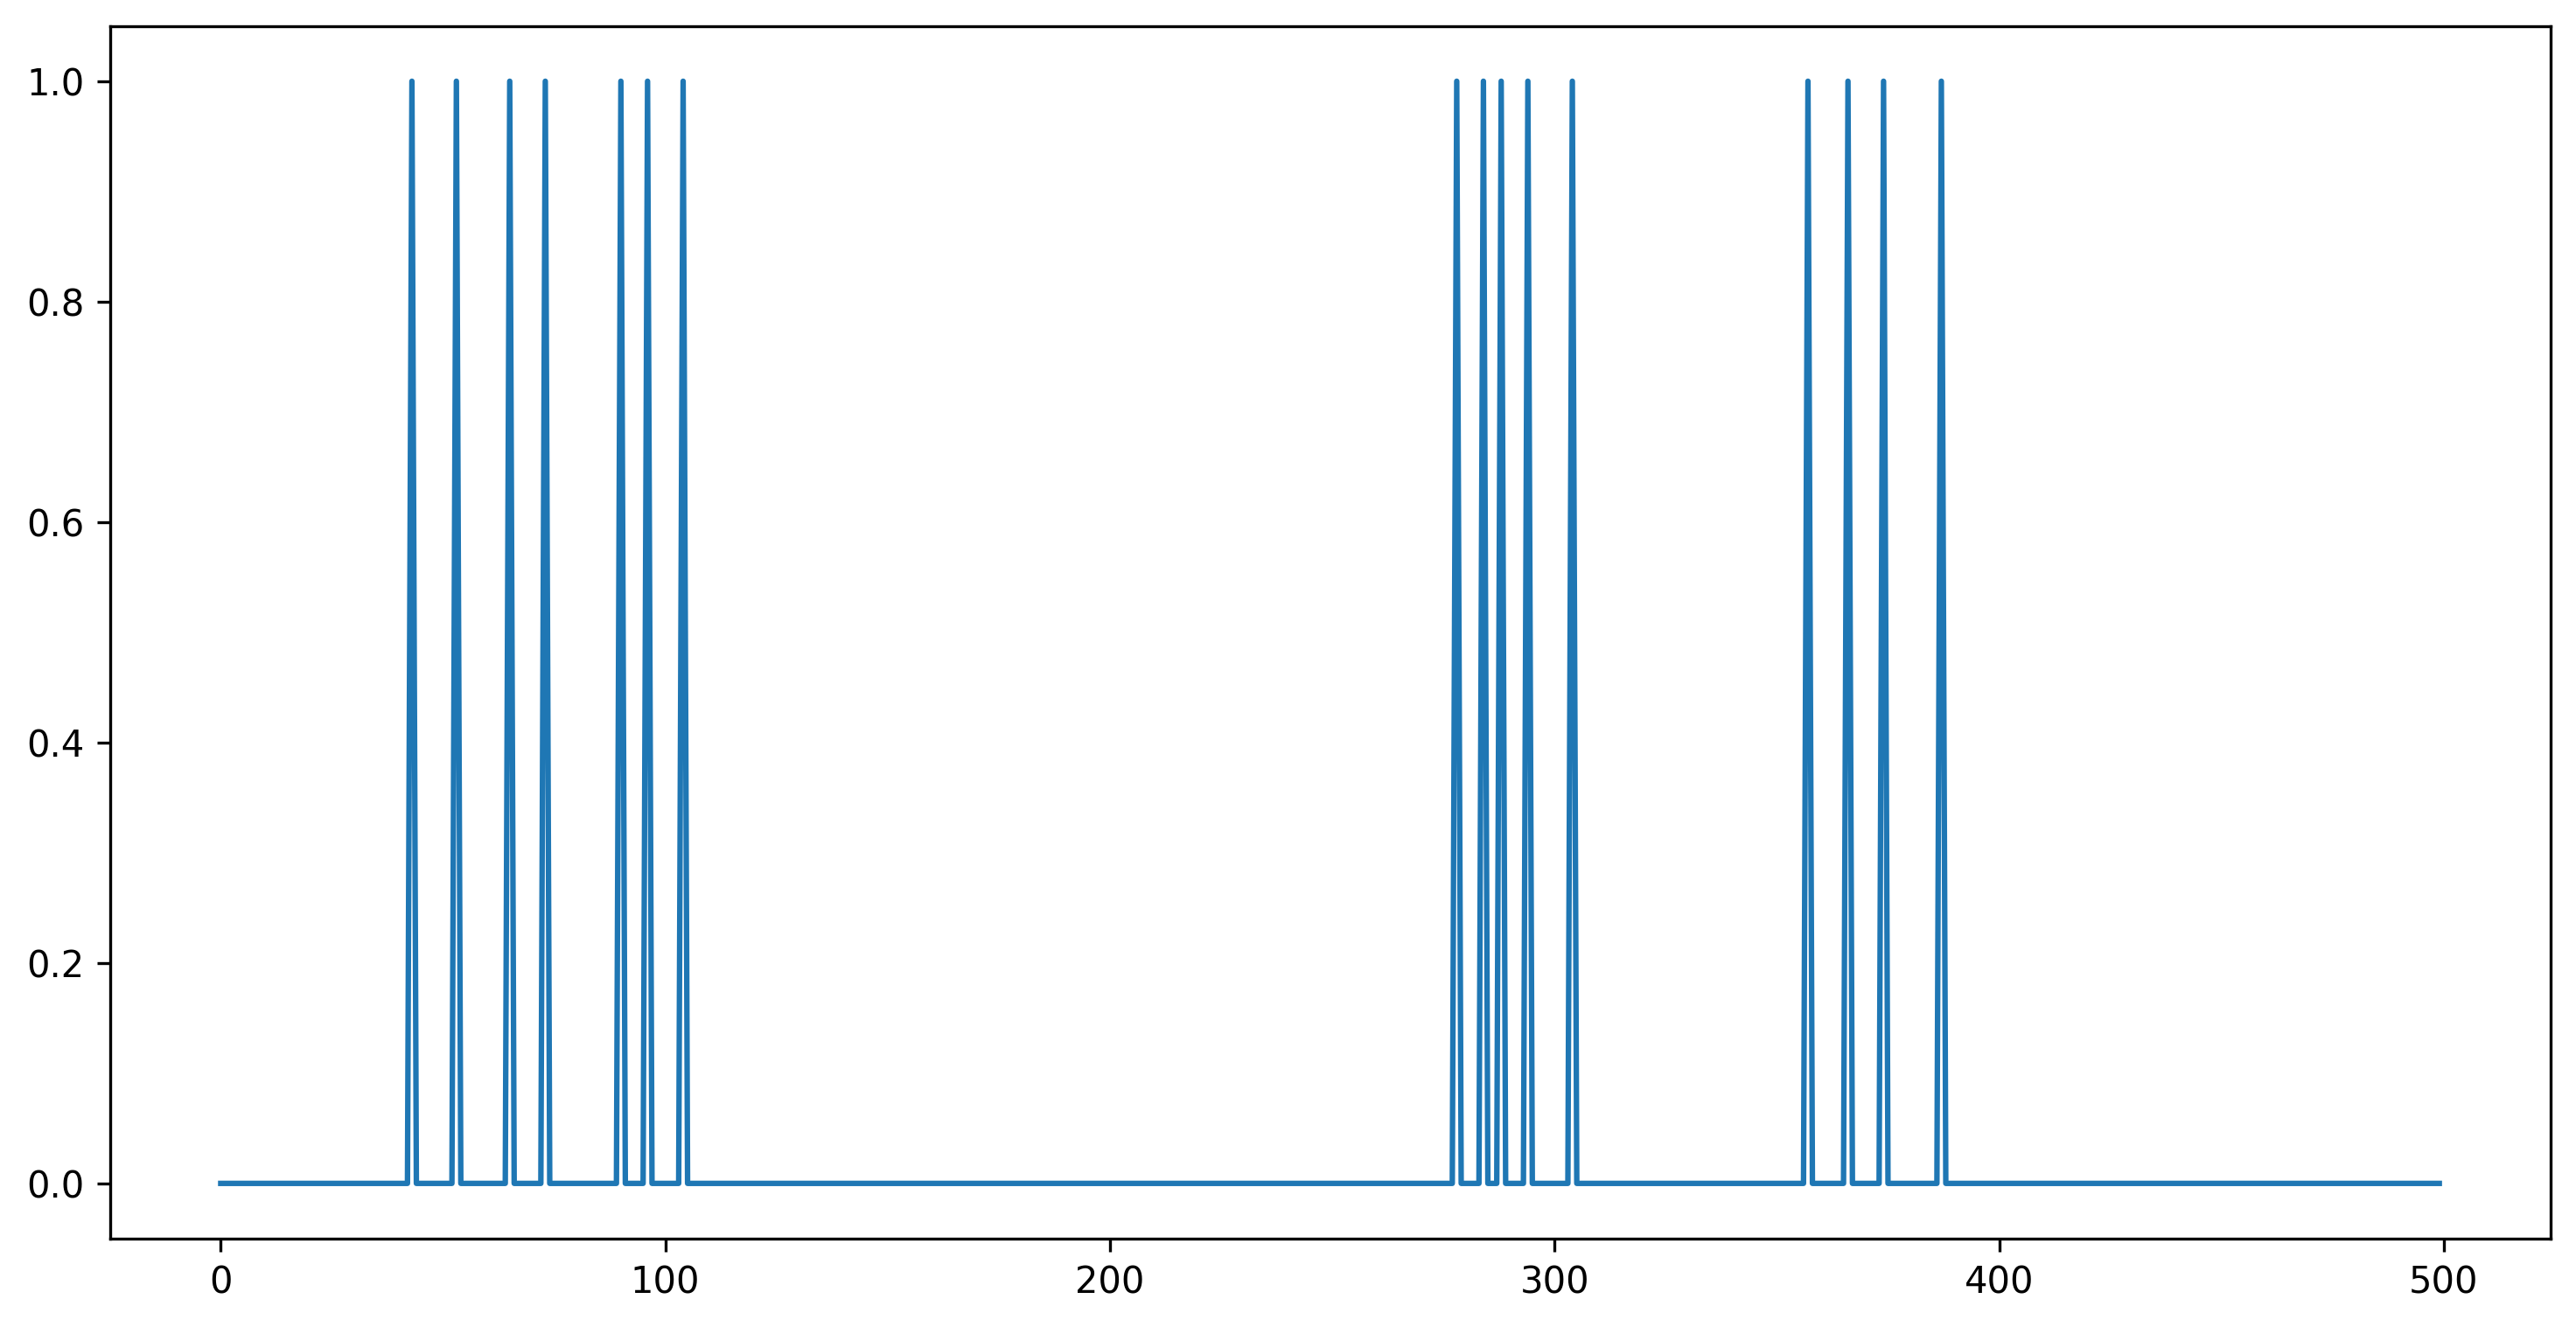

In [5]:
# - plot the output events
plt.plot(out.squeeze())

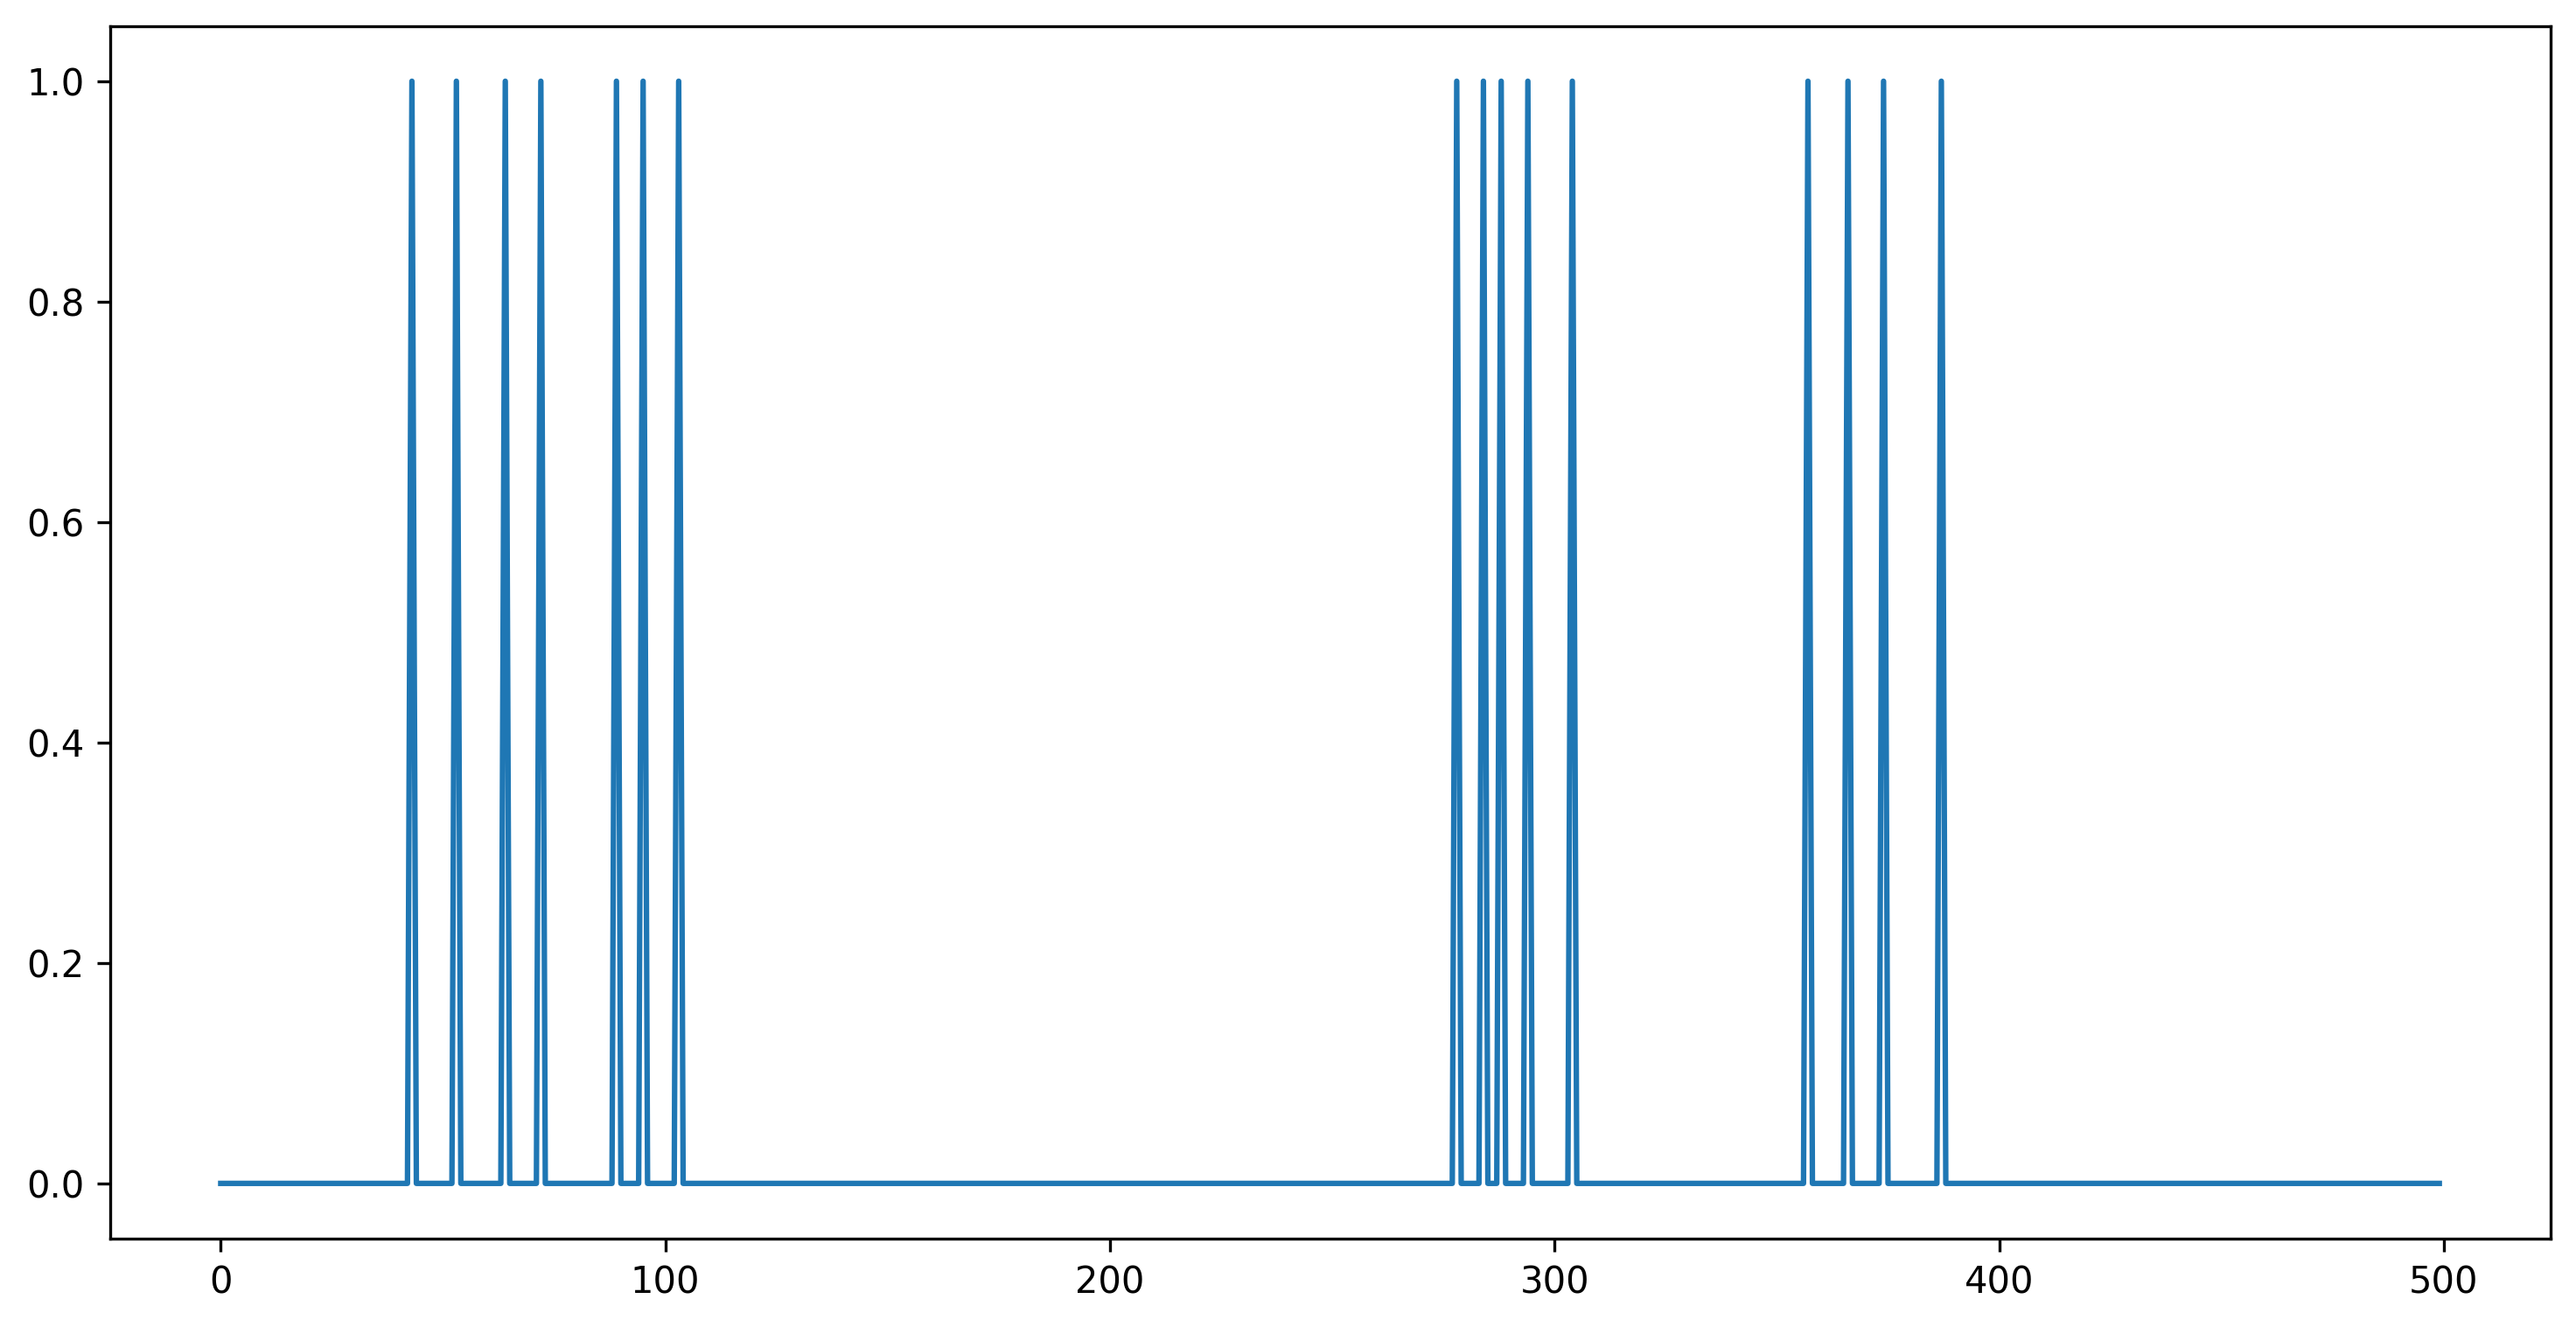

In [6]:
out, _, rec_dict = lif(input_sp, record = True)
plt.plot(out.squeeze())

In [7]:
rec_dict.keys()

dict_keys(['irec', 'spikes', 'isyn', 'vmem'])

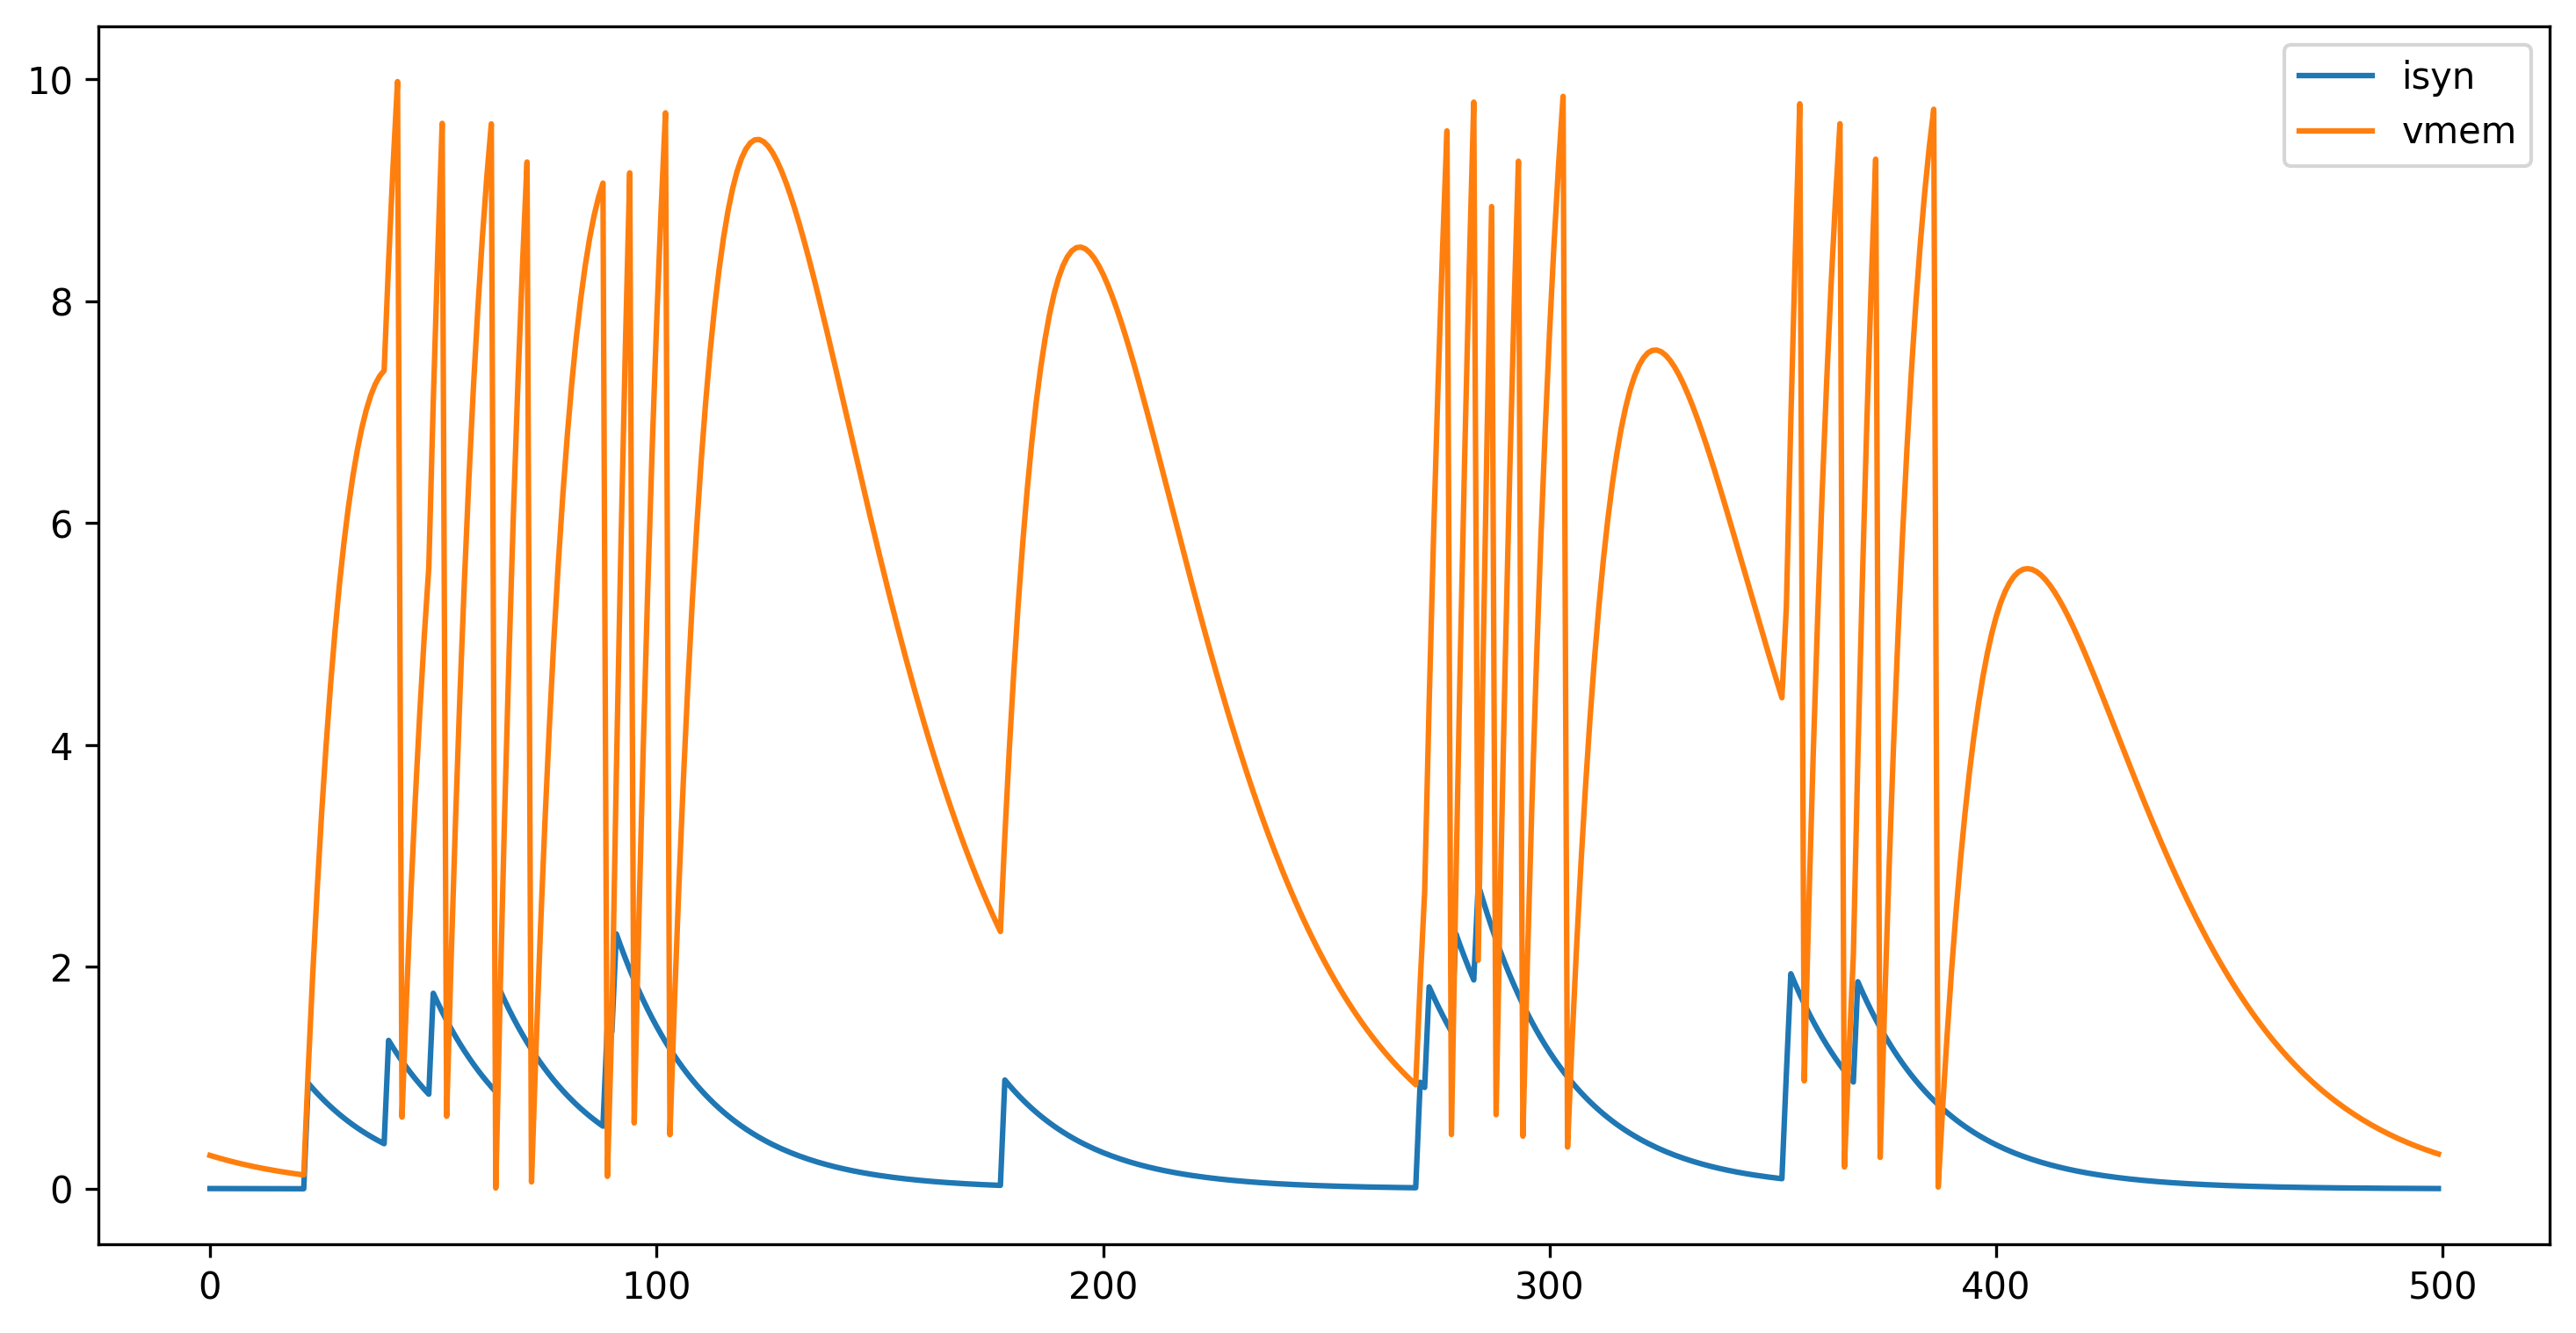

In [8]:
plt.plot(rec_dict['isyn'].squeeze(), label='isyn')
plt.plot(rec_dict['vmem'].squeeze(), label='vmem')
plt.legend()

In [9]:
lif.state()

{'spikes': array([0.]),
 'isyn': array([[0.00280706]]),
 'vmem': array([0.31445045])}

In [10]:
lif.parameters()

{'tau_mem': array([0.02]),
 'tau_syn': array([[0.02]]),
 'bias': array([0.]),
 'threshold': array(10.)}

In [11]:
lif.simulation_parameters()

{'_has_rec': False,
 'w_rec': array([[0.]]),
 'dt': 0.001,
 'noise_std': 0.0,
 'max_spikes_per_dt': 65536.0}

In [12]:
from rockpool.nn.modules import Linear, LIF

from rockpool.nn.combinators import Sequential

In [13]:
net = Sequential(
    Linear((2,2)),
    LIF((2)),
    
    Linear((2,3)),
    LIF((3)),

    Linear((3,2)),
    LIF((2)),
)
print(net)


ModSequential  with shape (2, 2) {
    Linear '0_Linear' with shape (2, 2)
    LIF '1_LIF' with shape (2, 2)
    Linear '2_Linear' with shape (2, 3)
    LIF '3_LIF' with shape (3, 3)
    Linear '4_Linear' with shape (3, 2)
    LIF '5_LIF' with shape (2, 2)
}

In [14]:
net.parameters('taus')

{'1_LIF': {'tau_mem': array([0.02, 0.02]),
  'tau_syn': array([[0.02],
         [0.02]])},
 '3_LIF': {'tau_mem': array([0.02, 0.02, 0.02]),
  'tau_syn': array([[0.02],
         [0.02],
         [0.02]])},
 '5_LIF': {'tau_mem': array([0.02, 0.02]),
  'tau_syn': array([[0.02],
         [0.02]])}}

In [15]:
net.state()

{'0_Linear': {},
 '1_LIF': {'spikes': array([0., 0.]), 'isyn': array([[0.],
         [0.]]), 'vmem': array([0., 0.])},
 '2_Linear': {},
 '3_LIF': {'spikes': array([0., 0., 0.]),
  'isyn': array([[0.],
         [0.],
         [0.]]),
  'vmem': array([0., 0., 0.])},
 '4_Linear': {},
 '5_LIF': {'spikes': array([0., 0.]),
  'isyn': array([[0.],
         [0.]]),
  'vmem': array([0., 0.])}}

In [16]:
import tonic
train_data = tonic.datasets.SHD('./data')
shd_timestep = 1e-6
shd_channels = 700
shd_classes = 20

C:\Users\guilh\anaconda3\envs\Rockpool\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


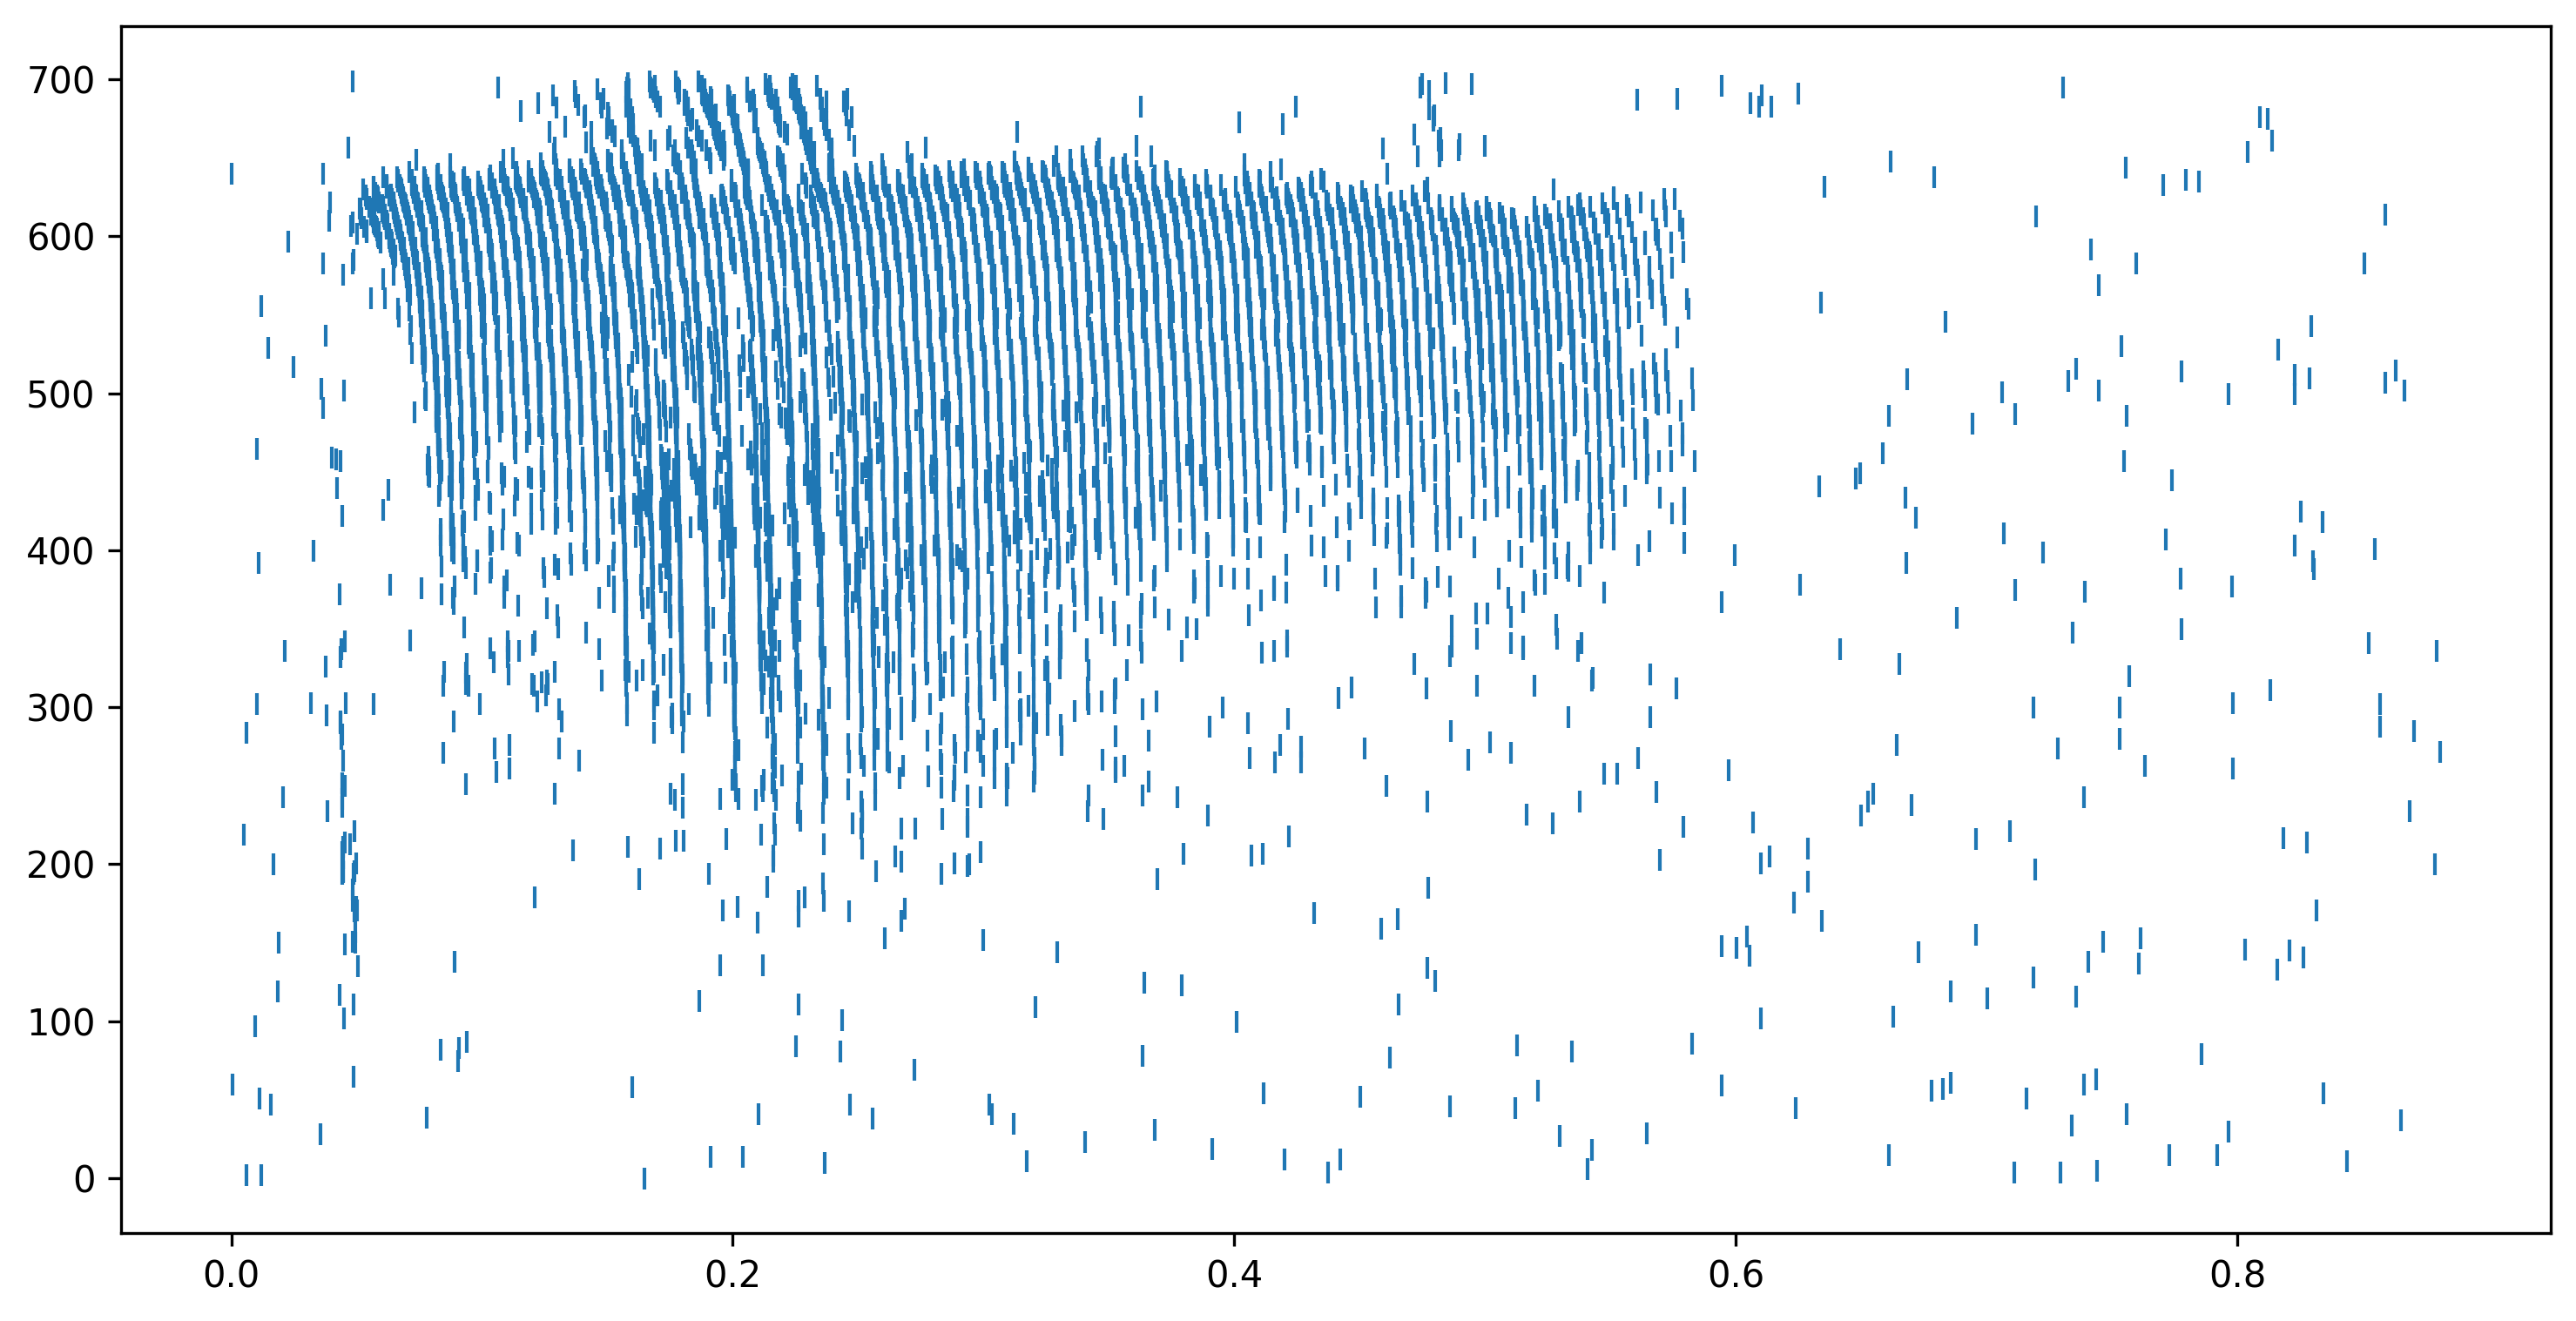

In [17]:
events, label = train_data[1]
times = events['t']*shd_timestep
channels = events['x']
plt.plot(times, channels, '|')

In [18]:
net_channels = 16
net_dt = 10e-3
sample_T = 250

In [19]:
import tonic.transforms as T

transform = T.Compose([
    T.Downsample(time_factor=shd_timestep/net_dt, spatial_factor=net_channels/shd_channels),

    T.ToFrame(sensor_size=(net_channels, 1, 1), time_window=1),

    torch.Tensor,

    lambda m: torch.squeeze(m)[:sample_T:, :],
])

In [20]:
train_data = tonic.datasets.SHD('./data', transform=transform)

In [21]:
raster, label = train_data[1]

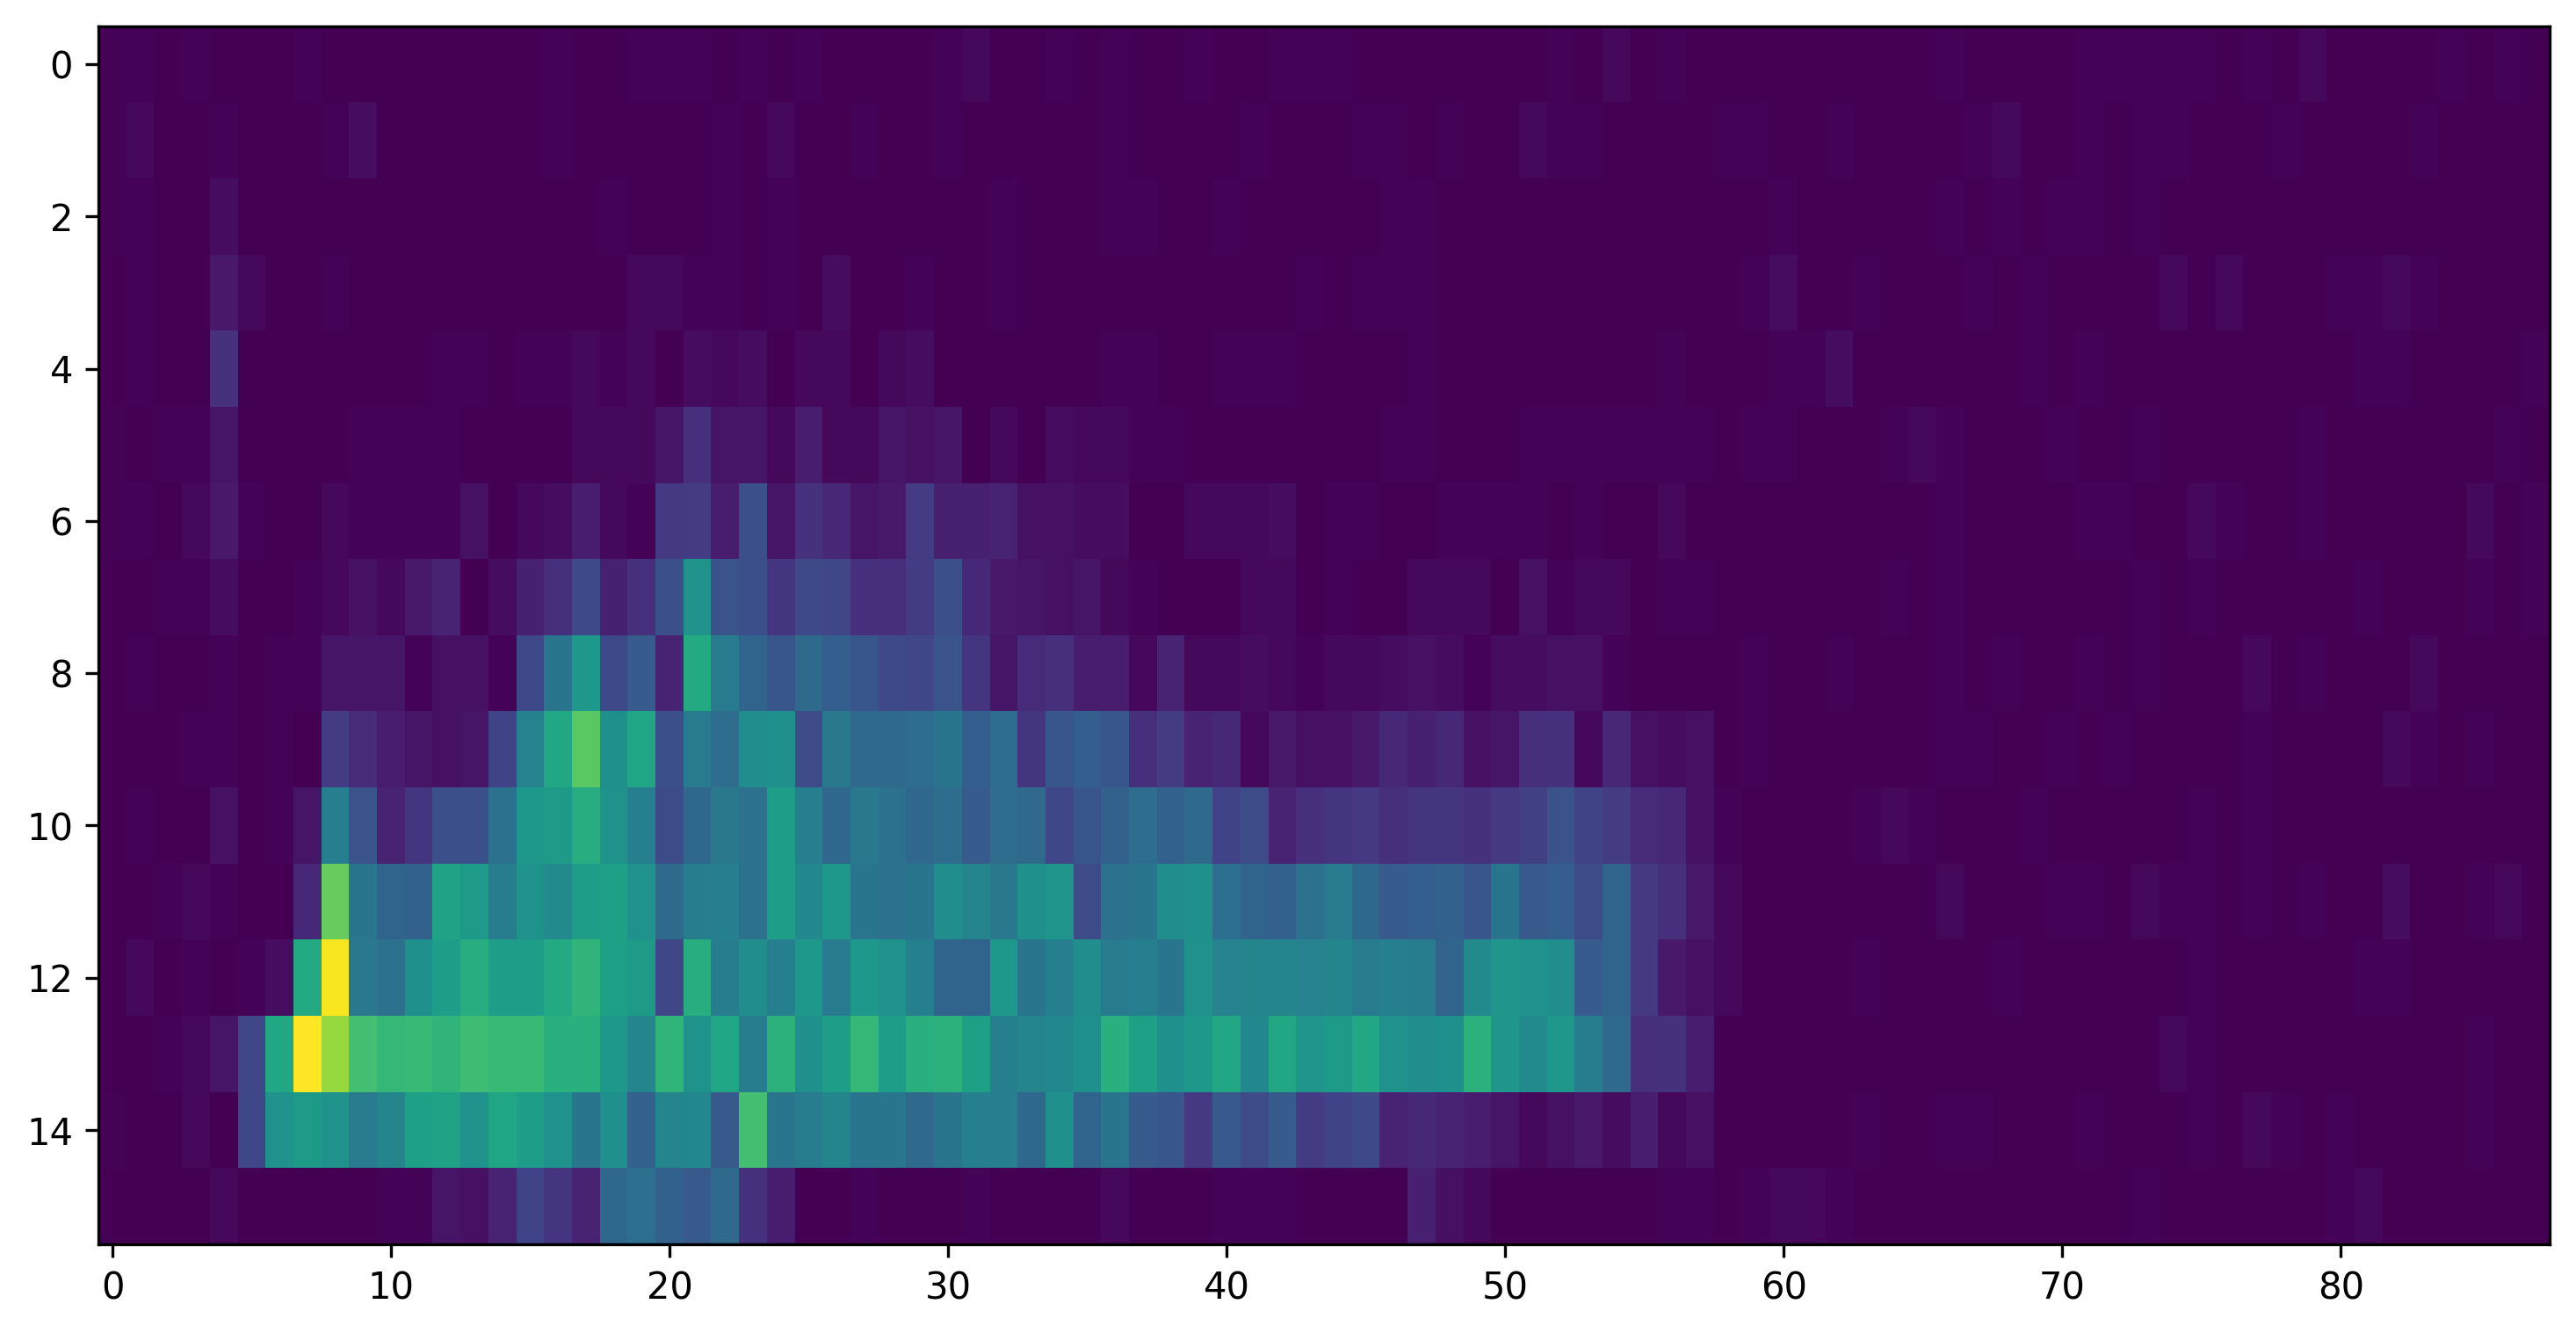

In [22]:
plt.imshow(raster.T, aspect ='auto')

In [23]:
# - Create a class which subsets a dataset to a list of matching labels
class SubsetClasses(torch.utils.data.Dataset):
    def __init__(self,
                 dataset,
                 match_labels,
                 ):
        indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label in match_labels:
                indices.append(idx)

        self._subset_ds = torch.utils.data.Subset(dataset, indices)
        self._len = len(indices)

    def __getitem__(self, index):
        return self._subset_ds[index]
    
    def __len__(self):
        return self._len

In [24]:
# - Define arguments for the data loader
dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=0,
)

# - Create the data loader, using `tonic` to provide a disk cache
train_dl = torch.utils.data.DataLoader(
    tonic.DiskCachedDataset(
        dataset=SubsetClasses(train_data, range(8)),
        cache_path=f"cache/{train_data.__class__.__name__}/train/{net_channels}/{net_dt}",
        reset_cache = False,
    ),
    **dataloader_kwargs
)

In [25]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

Nin = net_channels
Nhid = 20
Nout = 8

net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch((Nhid)),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch((Nhid)),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch((Nout)),
)

print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [26]:
net.parameters()

{'0_LinearTorch': {'weight': Parameter containing:
  tensor([[ 0.0141,  0.5953, -0.4144,  0.1765, -0.2873, -0.0521, -0.0510, -0.2063,
           -0.4016,  0.3661,  0.2531, -0.2930, -0.5290,  0.0026,  0.5622, -0.6038,
            0.2315, -0.2328, -0.0836, -0.0115],
          [-0.4434,  0.3017,  0.1083,  0.6110,  0.3807,  0.3016, -0.5926,  0.4160,
            0.2298, -0.1789,  0.0398,  0.0342, -0.3803,  0.3846,  0.5276, -0.3219,
           -0.3370, -0.6052, -0.2414, -0.0637],
          [-0.5187,  0.5001, -0.1665, -0.1718,  0.3931,  0.2145,  0.4051,  0.4904,
            0.0583,  0.0703,  0.1576,  0.4044, -0.4340, -0.2745,  0.0032, -0.2486,
            0.0310, -0.6119, -0.3746,  0.0957],
          [ 0.3281,  0.6021,  0.2542, -0.5694,  0.1668,  0.3233, -0.3921, -0.2299,
           -0.2296, -0.0904,  0.3644, -0.3885, -0.4365, -0.0152, -0.0140,  0.5266,
            0.4774,  0.3878, -0.3115,  0.5370],
          [ 0.0911, -0.2281, -0.2413,  0.3120, -0.5006,  0.1090, -0.1573, -0.4372,
          

In [27]:
from rockpool.parameters import Constant

neuron_parameters = {
    'tau_syn': Constant(20e-3),
    'tau_mem': Constant(50e-3),
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': net_dt,
}

# - Define the network with shared parameters
net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid, **neuron_parameters),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid, **neuron_parameters),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout, **neuron_parameters),
)

print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [28]:
net.parameters()

{'0_LinearTorch': {'weight': Parameter containing:
  tensor([[-0.3971, -0.2575, -0.3998, -0.4475, -0.4382, -0.5000,  0.1138, -0.5984,
           -0.0167,  0.3812, -0.0389, -0.4937, -0.3260, -0.6062, -0.4583,  0.5950,
           -0.2258,  0.1404,  0.5772, -0.1666],
          [ 0.0314, -0.2439,  0.0067, -0.5218, -0.3123, -0.0918, -0.3261,  0.4969,
            0.5521, -0.0750,  0.4126, -0.5101,  0.2028, -0.2145,  0.4943,  0.1509,
           -0.4000,  0.0640, -0.2732, -0.1189],
          [-0.1365, -0.5007, -0.3992,  0.1116, -0.0549, -0.4095, -0.0551, -0.5196,
           -0.1781,  0.0421,  0.1280, -0.1792, -0.4125, -0.5420,  0.4190,  0.4195,
            0.5458, -0.0399, -0.1273,  0.2422],
          [ 0.4114,  0.0636,  0.6033,  0.2267, -0.0303,  0.2984,  0.0477,  0.1257,
           -0.2876, -0.3162,  0.0487,  0.1677,  0.3471,  0.0643, -0.1820,  0.3892,
            0.2840, -0.3840, -0.1792, -0.2407],
          [-0.4298, -0.4330,  0.2555,  0.5748,  0.3635, -0.0412, -0.6094, -0.4187,
          

In [29]:
# - Import optimizer and loss function from pytorch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()

In [30]:
train_net = True

if train_net:
    # - Training Loop
    num_epochs = 10
    for e in range(num_epochs):

        # - Loop over dataset, getting batches
        for events, labels in train_dl:
            # - Zero the optimizer gradients
            optimizer.zero_grad()

            # - Evolve the network with this batch
            output, _, _ = net(events)

            # - Get the prediction -- number of spikes in each channel
            pred = torch.sum(output, dim=1)

            # - Get the loss value for this batch
            loss = loss_fun(pred, labels.long())
            
            # - Compute gradients with backward step and update parameters
            loss.backward()
            optimizer.step()

        # - Print the current loss
        print(f'Epoch {e}/{num_epochs}, loss {loss.item():.2e}')
        

Epoch 0/10, loss 4.30e+03

Epoch 1/10, loss 2.61e+03

Epoch 2/10, loss 1.06e+03

Epoch 3/10, loss 7.00e+02

Epoch 4/10, loss 4.18e+02

Epoch 5/10, loss 4.22e+02

Epoch 6/10, loss 3.23e+02

Epoch 7/10, loss 3.02e+02

Epoch 8/10, loss 2.22e+02

Epoch 9/10, loss 1.89e+02

In [31]:
net.load('pretrained-20ke.json')

In [32]:
events, label = train_data[2]
out, _, rd = net(events, record = True)

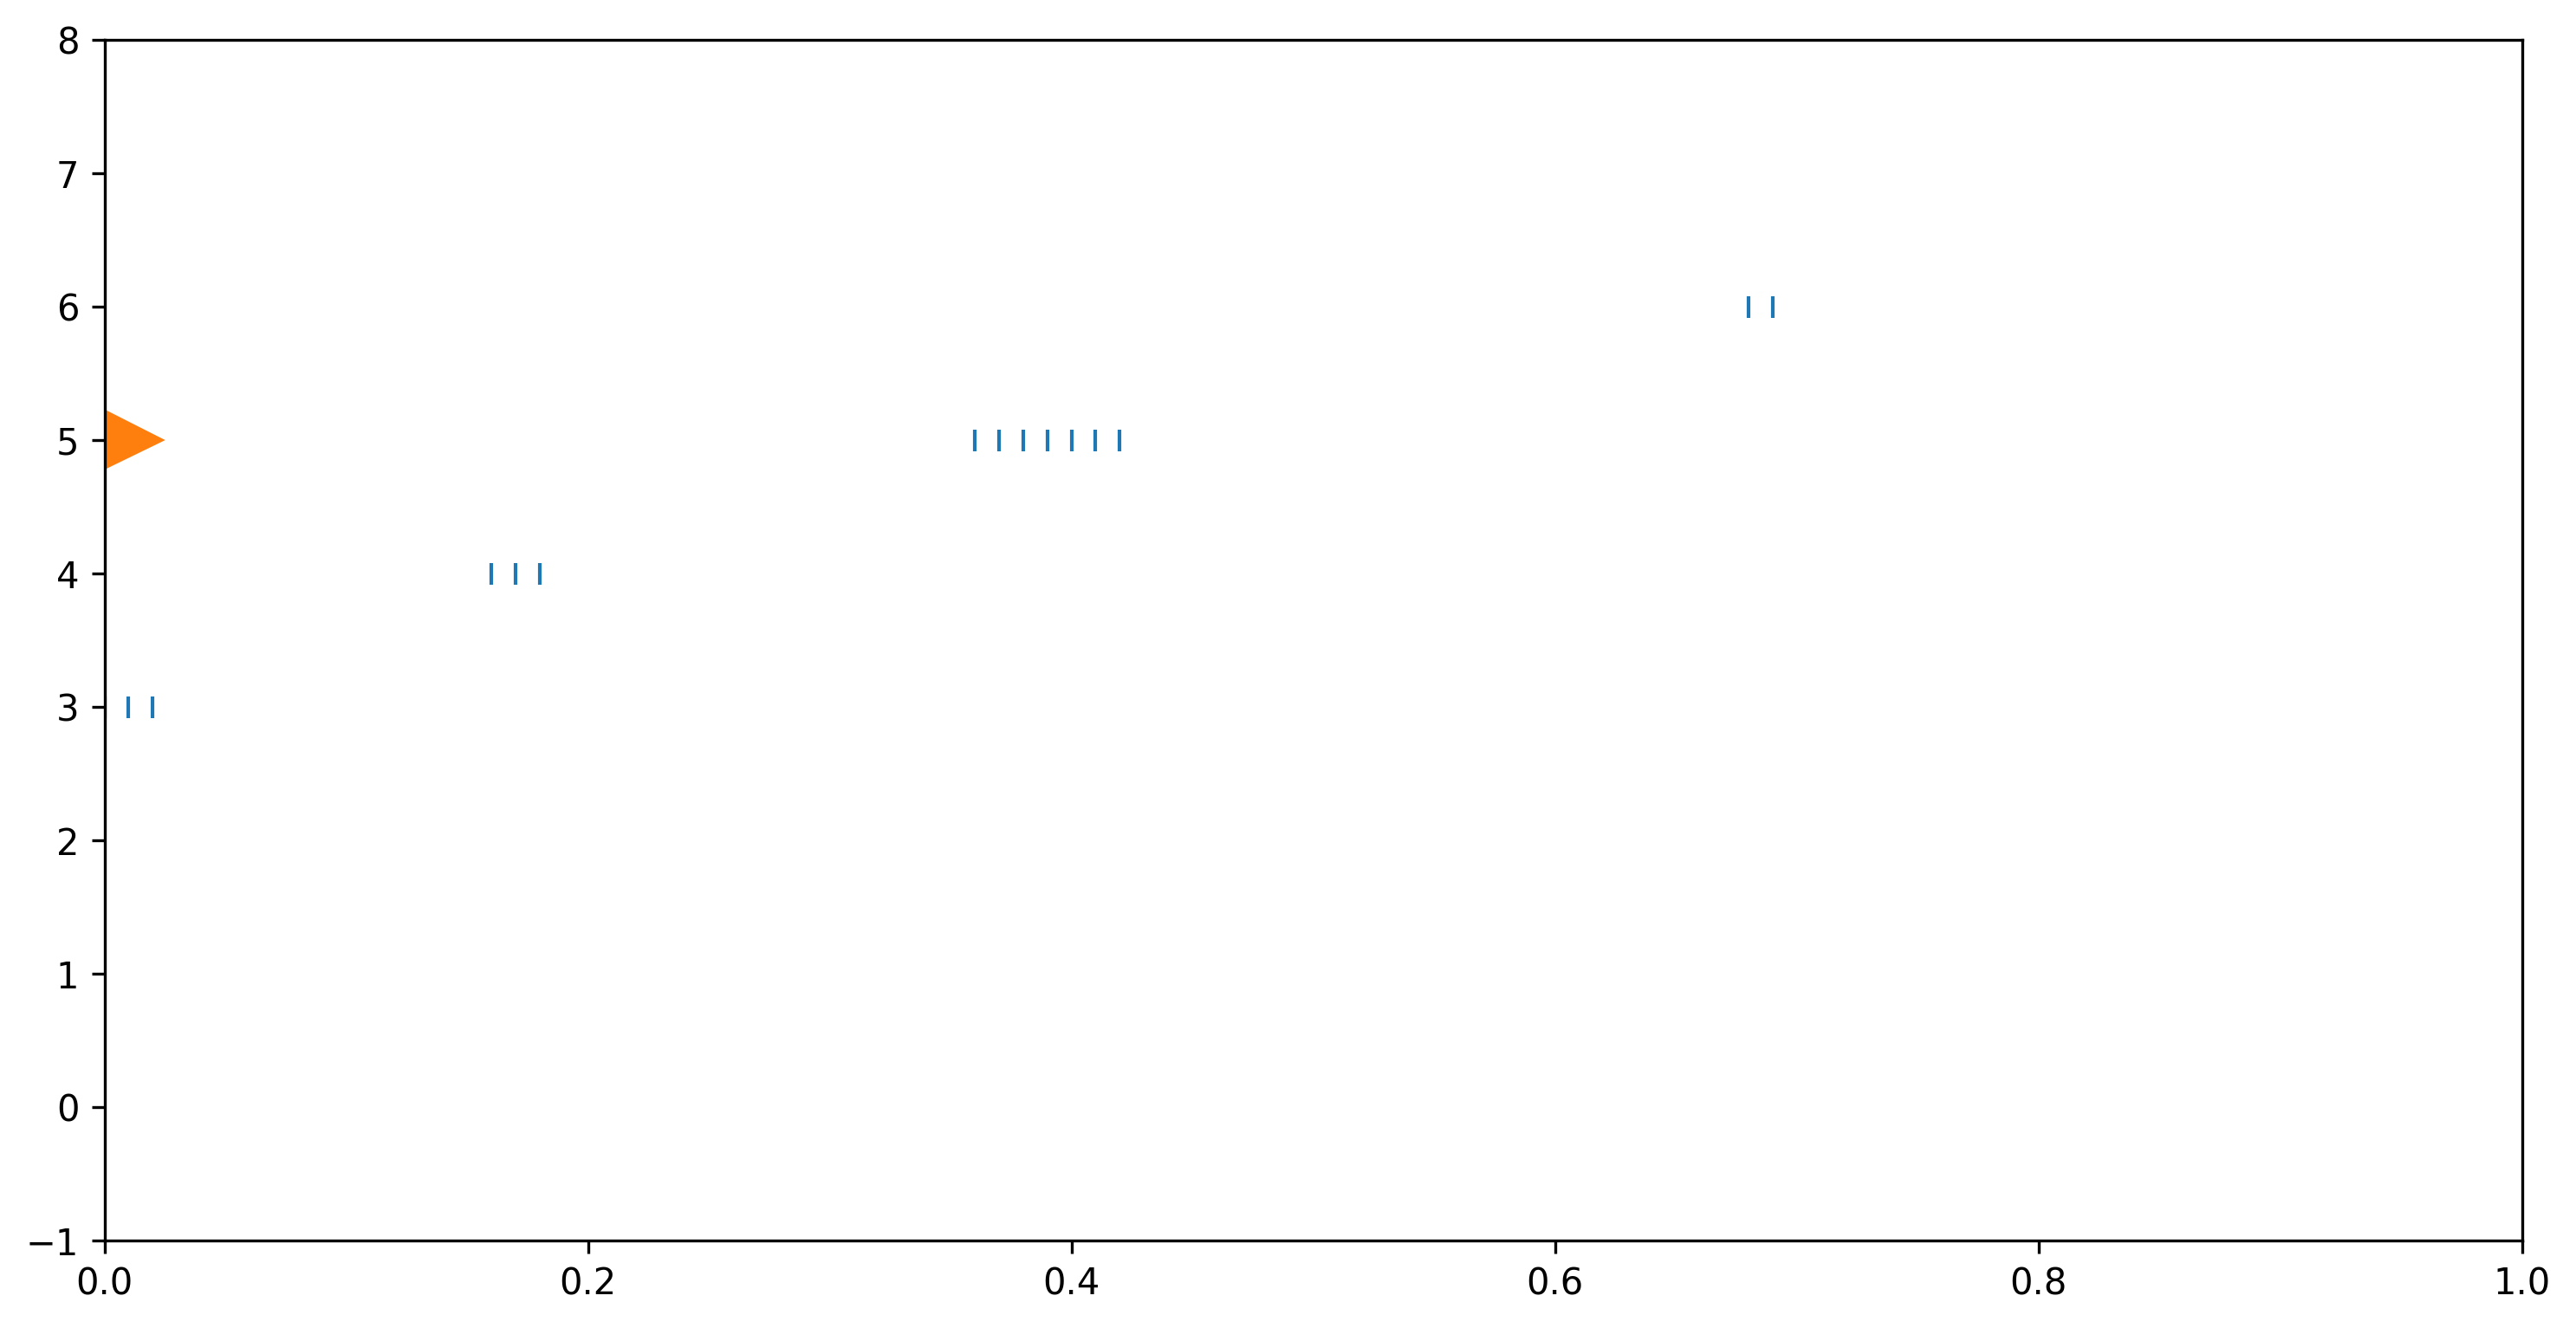

In [35]:
times, channels = torch.where(out[0])
plt.plot(times*net_dt, channels, '|')
plt.xlim([0,1])
plt.ylim([-1,8])
plt.plot(0.01, label, '>', ms=18)

Not spike time dependent plasticity!
Gradient based training for performancing reasons

In [36]:
net.as_graph()

GraphHolder "TorchSequential__1780393936272" with 16 input nodes -> 8 output nodes